## **Project 5  Car_Price_Prediction**             
        
***Выполнила Хуснуллина Наиля***       
***

# 1. Импорт библиотек

In [164]:
import numpy as np 
import pandas as pd 
import re
#import sys
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.feature_selection import f_classif, mutual_info_classif

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
#from sklearn.linear_model import LogisticRegression

In [165]:
# зафиксируем версию пакетов
!pip freeze > requirements.txt

In [166]:
# фиксируем RANDOM_SEED
RANDOM_SEED = 42

# 2. Импорт данных

In [167]:
#импотр для каггла
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

#PATH_to_file = '/kaggle/input/sf-dst-car-price-prediction/'
#PATH_to_file_data = '/kaggle/input/auto-ru-parsing-06-01-2021/'

In [168]:
#train = pd.read_csv(PATH_to_file_data +'auto_ru_06_01_2021.csv')
#test = pd.read_csv(PATH_to_file+'test.csv')
#submit = pd.read_csv(PATH_to_file+'sample_submission.csv')
#импорт для локального компа
train = pd.read_csv('auto_ru_06_01_2021.csv')
test = pd.read_csv('test.csv')
submit = pd.read_csv('sample_submission.csv')

In [169]:
# удалим дубликаты из трейна
train.drop_duplicates(subset=['complectation_dict', 'sell_id', 'description'], keep=False, inplace=True)

In [170]:
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', train.shape)
display(train.head(2))
print('Размерность тестового датасета: ', test.shape)
display(test.head(2))
print('Размерность датасета c примером сабмишена: ', submit.shape)
display(submit.head(2))

Размерность тренировочного датасета:  (74223, 39)


,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,tax_by_year,transport_tax_rid,insurance_company,osago_insurance_price,start_date,auto_class,price_RUR,price_EUR,price_USD
0,Универсал 5 дв.,AUDI,EE1D19,{'id': '0'},По кузову всё хорошо. По ходовой хорошо.Технич...,2.0,115.0,"{'esp': True, 'hatch': True, 'ashtray-and-ciga...",бензин,//avatars.mds.yandex.net/get-autoru-vos/173544...,300000,1990.0,"{'code': '100', 'name': '100', 'ru_name': '100...",100,2.0 MT (115 л.с.),5.0,RUR,1994,1101790208,"{'id': '7879503', 'displacement': 1984, 'engin...",WAGON_5_DOORS MECHANICAL 2.0,MECHANICAL,EUROPEAN,2.0,"{'year': 2004, 'month': 11}",ORIGINAL,передний,LEFT,True,True,2875.0,213.0,TINKOFF,4732.0,2020-12-04T08:37:24Z,E,198000.0,2181.0,2653.0
1,Седан,AUDI,CACECB,{'id': '0'},Автомобиль в хорошем состоянии много нового но...,2.3,133.0,{},бензин,//avatars.mds.yandex.net/get-autoru-vos/216022...,420000,1990.0,"{'code': '100', 'name': '100', 'ru_name': '100...",100,2.3 MT (133 л.с.),4.0,RUR,1991,1102081523,"{'id': '7879487', 'displacement': 2309, 'engin...",SEDAN MECHANICAL 2.3,MECHANICAL,EUROPEAN,3.0,NaN,ORIGINAL,передний,LEFT,True,True,4655.0,213.0,TINKOFF,5521.0,2021-01-04T09:55:08Z,E,140000.0,1542.0,1876.0


Размерность тестового датасета:  (34686, 32)


,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


Размерность датасета c примером сабмишена:  (34686, 2)


,sell_id,price
0,1100575026,0
1,1100549428,0


In [171]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74223 entries, 0 to 75440
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bodyType               74221 non-null  object 
 1   brand                  74223 non-null  object 
 2   color                  74223 non-null  object 
 3   complectation_dict     74223 non-null  object 
 4   description            71209 non-null  object 
 5   engineDisplacement     74221 non-null  object 
 6   enginePower            74221 non-null  float64
 7   equipment_dict         74223 non-null  object 
 8   fuelType               74223 non-null  object 
 9   image                  74223 non-null  object 
 10  mileage                74223 non-null  int64  
 11  modelDate              74221 non-null  float64
 12  model_info             74223 non-null  object 
 13  model_name             74223 non-null  object 
 14  name                   74221 non-null  object 
 15  nu

In [172]:
train.isna().sum()

bodyType                     2
brand                        0
color                        0
complectation_dict           0
description               3014
engineDisplacement           2
enginePower                  2
equipment_dict               0
fuelType                     0
image                        0
mileage                      0
modelDate                    2
model_info                   0
model_name                   0
name                         2
numberOfDoors                2
priceCurrency              212
productionDate               0
sell_id                      0
super_gen                    2
vehicleConfiguration         2
vehicleTransmission          2
vendor                       0
Владельцы                21853
Владение                 58637
ПТС                        410
Привод                       2
Руль                         0
Состояние                    0
Таможня                      0
tax_by_year                424
transport_tax_rid          424
insuranc

**train**       
39 признаков      
74223 записей        
Числовой тип данных: mileage, productionDate, sell_idenginePower - 3 признака тип int;         
                    enginePower, modelDate, numberOfDoors, Владельцы, tax_by_year, transport_tax_rid, osago_insurance_price, price_RUR, price_EUR, price_USD - 10 признаков тип float.         
Булевых признаков 2: Состояние, Таможня.      
Остальные 24 признака имеют тип object.          
                              
Много пропущенных значений у признака Владение, Владельцы. Имется по 2 пропущенных значения по многим признакам - можно предположить что это пара объявлений без информации.

У целевого признака price_RUR также имеются пропущенные значения. Сразу удалим их и почистим строки, в которых много пропущенных значений.

In [173]:
train.dropna(subset=['price_RUR','bodyType','Привод'], inplace=True)

In [174]:
# Удалим столбцы трейна, которых нет в test, кроме price_RUR
columns_drop = ['tax_by_year', 'transport_tax_rid', 'osago_insurance_price',
                'insurance_company', 'start_date', 'auto_class', 'price_EUR', 'price_USD']
train.drop(columns_drop, axis=1, inplace=True)

In [175]:
print('Размерность тренировочного датасета: ', train.shape)
print('Размерность тестового датасета: ', test.shape)

Размерность тренировочного датасета:  (74009, 31)
Размерность тестового датасета:  (34686, 32)


In [176]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [177]:
test.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

**test**                  
32 признака (не включая целевую переменную)                        
34686 записей                     
Числовой тип признаков: mileage, modelDate, numberOfDoors, parsing_unixtime, productionDate, sell_id - 6 признаков тип int.                          
Остальные 26 признаков типа object.                            
Три признака имеют почти 10000 - 28000 пропущенных значений (complectation_dict, equipment_dict, Владение).                

# 3. Предобработка датасетов

Предварительный просмотр данных train и test выявил следующее:          
* валюта всех объявлений (priceCurrency) - рубли;                      
* все автомобили не требуют ремонта (Состояние);
* все растоможены(Таможня);       
* в train нет признаков car_url и parsing_unixtime.        

Бинарные признаки:
* ПТС: у большинства оригинал (train - 67147 / 6452 / 410nan, test - 30098 / 4587 / 1nan)

In [178]:
# Удалим признаки, в которых 1 значение - Состояние, Таможня и priceCurrency
columns_drop = ['Состояние', 'Таможня', 'priceCurrency']
train.drop(columns_drop, axis=1, inplace=True)
test.drop(columns_drop, axis=1, inplace=True)

In [179]:
# Удалим car_url и parsing_unixtime из test
columns_drop = ['car_url', 'parsing_unixtime']
test.drop(columns_drop, axis=1, inplace=True)

In [180]:
#заменим пропущенные значение в ПТС на наиболее часто встречающеся
test['ПТС'] = test['ПТС'].fillna('Оригинал')
train['ПТС'] = train['ПТС'].fillna('ORIGINAL')

In [181]:
# Числовые признаки приведем к единому формату 
train['modelDate'] = train['modelDate'].values.astype('int64')
train['numberOfDoors'] = train['numberOfDoors'].values.astype('int64')

In [182]:
test['enginePower'] = test['enginePower'].apply(lambda x: x.replace(' N12', ''))

train['enginePower'] = train['enginePower'].values.astype('int64')
test['enginePower'] = test['enginePower'].values.astype('int64')

# 4. Анализ данных

### 4.1. Целевая переменная price_RUR

In [183]:
train.price_RUR.describe()

count    7.400900e+04
mean     1.856675e+06
std      2.515073e+06
min      2.000000e+04
25%      5.000000e+05
50%      1.050000e+06
75%      2.061000e+06
max      6.990000e+07
Name: price_RUR, dtype: float64

In [184]:
train[train.price_RUR <= 20000]

,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,price_RUR
31695,Хэтчбек 5 дв.,MAZDA,97948F,{'id': '0'},Доброго времени суток. Предлагаю Вашему вниман...,2.0,115,"{'tinted-glass': True, 'airbrush': True, 'keyl...",бензин,//avatars.mds.yandex.net/get-autoru-vos/216417...,300000,1991,"{'code': '626', 'name': '626', 'ru_name': '626...",626,2.0 MT (115 л.с.),5,1992,1102045581,"{'id': '7950400', 'displacement': 1991, 'engin...",HATCHBACK_5_DOORS MECHANICAL 2.0,MECHANICAL,JAPANESE,3.0,NaN,ORIGINAL,передний,LEFT,20000.0


In [185]:
train[train.price_RUR > 55000000]

,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,price_RUR
44551,Кабриолет,PORSCHE,97948F,{'id': '0'},Porsche 356 Speedster 1956 года. \nОдин из 300...,1.6,105,"{'12v-socket': True, 'drl': True}",бензин,//avatars.mds.yandex.net/get-autoru-vos/199857...,1,1955,"{'code': '356', 'name': '356', 'ru_name': '356...",356,1.6 MT (105 л.с.),2,1956,1101189676,"{'id': '20663277', 'displacement': 1587, 'engi...",CABRIO MECHANICAL 1.6,MECHANICAL,EUROPEAN,1.0,"{'year': 1956, 'month': 4}",ORIGINAL,задний,LEFT,59604352.0
67219,Пикап Двойная кабина,MERCEDES,040001,"{'id': '20067541', 'name': 'G63 AMG 6x6', 'ava...",NaN,63,544,"{'asr': True, 'tinted-glass': True, 'roller-bl...",бензин,//avatars.mds.yandex.net/get-autoru-vos/172067...,7000,2013,"{'code': 'G_KLASSE_AMG_6X6', 'name': 'G-Класс ...",G_KLASSE_AMG_6X6,63 AMG 5.5 AT (544 л.с.) 4WD,4,2014,1101930525,"{'id': '9332420', 'name': '63 AMG', 'nameplate...",PICKUP_TWO AUTOMATIC 63,AUTOMATIC,EUROPEAN,1.0,NaN,ORIGINAL,полный,LEFT,69900000.0
72031,Седан,MERCEDES,040001,"{'id': '21193010', 'name': 'S 650', 'available...",Гарантия сохранения цены.\n\nФинал продаж 2020...,650,630,"{'228': True, '401': True, '443': True, '531':...",бензин,//avatars.mds.yandex.net/get-autoru-vos/392251...,0,2017,"{'code': 'S_CLASS_MAYBACH', 'name': 'Maybach S...",S_CLASS_MAYBACH,650 6.0 AT (630 л.с.),4,2018,1102088455,"{'id': '21192981', 'name': '650', 'nameplate':...",SEDAN AUTOMATIC 650,AUTOMATIC,EUROPEAN,NaN,NaN,ORIGINAL,задний,LEFT,58387500.0
72036,Седан,MERCEDES,040001,"{'id': '21193010', 'name': 'S 650', 'available...",Гарантия сохранения цены.\n\nФинал продаж 2020...,650,630,"{'228': True, '401': True, '443': True, '531':...",бензин,//avatars.mds.yandex.net/get-autoru-vos/429713...,0,2017,"{'code': 'S_CLASS_MAYBACH', 'name': 'Maybach S...",S_CLASS_MAYBACH,650 6.0 AT (630 л.с.),4,2018,1102088453,"{'id': '21192981', 'name': '650', 'nameplate':...",SEDAN AUTOMATIC 650,AUTOMATIC,EUROPEAN,NaN,NaN,ORIGINAL,задний,LEFT,58387500.0
72037,Седан,MERCEDES,040001,"{'id': '21193010', 'name': 'S 650', 'available...",Гарантия сохранения цены.\n\nФинал продаж 2020...,650,630,"{'228': True, '401': True, '443': True, '531':...",бензин,//avatars.mds.yandex.net/get-autoru-vos/196497...,0,2017,"{'code': 'S_CLASS_MAYBACH', 'name': 'Maybach S...",S_CLASS_MAYBACH,650 6.0 AT (630 л.с.),4,2018,1102088568,"{'id': '21192981', 'name': '650', 'nameplate':...",SEDAN AUTOMATIC 650,AUTOMATIC,EUROPEAN,NaN,NaN,ORIGINAL,задний,LEFT,58387500.0
72039,Седан,MERCEDES,040001,"{'id': '21193010', 'name': 'S 650', 'available...",Гарантия сохранения цены.\n\nФинал продаж 2020...,650,630,"{'228': True, '401': True, '443': True, '531':...",бензин,//avatars.mds.yandex.net/get-autoru-vos/195978...,0,2017,"{'code': 'S_CLASS_MAYBACH', 'name': 'Maybach S...",S_CLASS_MAYBACH,650 6.0 AT (630 л.с.),4,2018,1102088565,"{'id': '21192981', 'name': '650', 'nameplate':...",SEDAN AUTOMATIC 650,AUTOMATIC,EUROPEAN,NaN,NaN,ORIGINAL,задний,LEFT,58387500.0
72044,Седан,MERCEDES,040001,"{'id': '21193010', 'name': 'S 650', 'available...",Гарантия сохранения цены.\n\nФинал продаж 2020...,650,630,"{'228': True, '401': True, '443': True, '531':...",бензин,//avatars.mds.yandex.net/get-autoru-vos/414577...,0,2017,"{'code': 'S_CLASS_MAYBACH', 'name': 'Maybach S...",S_CLASS_MAYBACH,650 6.0 AT (630 л.с.),4,2018,1101820797,"{'id': '21192981', 'name': '650', 'nameplate':...",SEDAN AUTOMATIC 650,AUTOMATIC,EUROPEAN,NaN,NaN,ORIGINAL,задний,LEFT,58423400.0
72045,Седан,MERCEDES,CACECB,"{'id': '21193010', 'name': 'S 650', 'available...",Гарантия сохранения цены.\n\nФинал продаж 2020...,650,630,"{'228': True, '301': True, '401': True, '531':...",бензин,//avatars.mds.yandex.net/get-autoru-vos/204962...,0,2017,"{'code': 'S_CLASS_MAYBACH', 'name': 'Maybach S...",S_

Ценовой диапазон ограничивать не будем.

<AxesSubplot:>

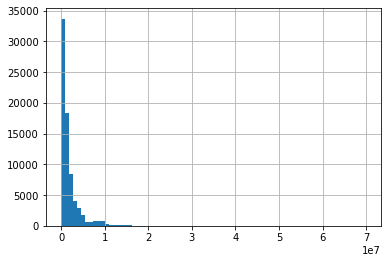

In [186]:
train['price_RUR'].hist(bins=77)

<AxesSubplot:>

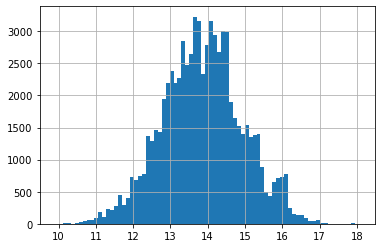

In [187]:
train['log_price'] = np.log(train.price_RUR)
train['log_price'].hist(bins=77)

Логарифмирование привело к нормальному распределению.        

### 4.2. sell_id

In [188]:
test.sell_id.nunique()

34686

In [189]:
train.sell_id.nunique()

74009

Все данные уникальны.
Это столбец для генерации файла submition. Не трогаем.

Рассмотрим внимательнее признаки, которые, возможно, содержат информацию, которую нужно разделить на несколько признаков.

### 4.3. complectation_dict

In [190]:
print(f'Признак содержит {train.complectation_dict.isna().sum()} пропущенных значений в трейне и {test.complectation_dict.isna().sum()} в тесте')

Признак содержит 0 пропущенных значений в трейне и 28268 в тесте


In [191]:
train.complectation_dict.value_counts().head(2)

{'id': '0'}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

Судя по данным, complectation_dict содержит информацию о комплектации, цвете машины, а также ссылки на фото. В train 41850 нулевых значения. Из-за большого количества пропусков удалим признак.

In [192]:
test.drop('complectation_dict', axis=1, inplace=True)
train.drop('complectation_dict', axis=1, inplace=True)

### 4.4. description

In [193]:
test.description[0]

'Все автомобили, представленные в продаже, проходят тщательную проверку по более 40 параметрам. Предоставляем гарантию юридической чистоты, а так же год технической гарантии на двигатель и КПП. Бесплатный тест-драйв. Возможно оформление автомобиля в кредит!\n\nПреимущества автокредитования:\n— Первоначальный взнос от 0%;\n— Более 30 кредитных программ;\n— Процентная ставка от 6% годовых;\n— Срок кредита от 6 месяцев до 7 лет;\n— Оформление кредита по двум документам;\n— Досрочное погашение без штрафов и комиссий;\n— Сумма кредита до 2 млн рублей;\n— Оформление КАСКО – по желанию;\n— Без справок и поручителей.\n\nСотрудничаем с 12 аккредитованными и сертифицированными банками РФ, среднее время ожидания решения банка 20–30 минут.\n\nПри покупке автомобиля по программе «Trade-in – выгодный обмен» или в кредит, получите дополнительную скидку до 80 000 рублей на данный автомобиль!\n\nЗаписаться на тест-драйв, а так же получить подробную информацию можно у специалистов автоцентра по указанно

In [194]:
test.description = test.description.astype('str')
train.description = train.description.astype('str') #странно, но без этого иногда ругается 

In [195]:
# Выделим некоторые словосочетания из описаний в признаки
train['офДил'] = train.description.apply(lambda x: 1 if 'официального дилера' in x else 0)
test['офДил'] = test.description.apply(lambda x: 1 if 'официального дилера' in x else 0)
train['климат'] = train.description.apply(lambda x: 1 if 'климат контроль' in x else 0)
test['климат'] = test.description.apply(lambda x: 1 if 'климат контроль' in x else 0)
train['подБез'] = train.description.apply(lambda x: 1 if 'подушки безопасности' in x else 0)
test['подБез'] = test.description.apply(lambda x: 1 if 'подушки безопасности' in x else 0)
train['усилРуля'] = train.description.apply(lambda x: 1 if 'усилитель руля' in x else 0)
test['усилРуля'] = test.description.apply(lambda x: 1 if 'усилитель руля' in x else 0)
train['отл'] = train.description.apply(lambda x: 1 if 'отличном состоянии' in x else 0)
test['отл'] = test.description.apply(lambda x: 1 if 'отличном состоянии' in x else 0)
train['хор'] = train.description.apply(lambda x: 1 if 'хорошем состоянии' in x else 0)
test['хор'] = test.description.apply(lambda x: 1 if 'хорошем состоянии' in x else 0)
train['цЗамок'] = train.description.apply(lambda x: 1 if 'центральный замок' in x else 0)
test['цЗамок'] = test.description.apply(lambda x: 1 if 'центральный замок' in x else 0)
train['эПодъм'] = train.description.apply(lambda x: 1 if 'электростеклоподъемники' in x else 0)
test['эПодъм'] = test.description.apply(lambda x: 1 if 'электростеклоподъемники' in x else 0)
train['бКомп'] = train.description.apply(lambda x: 1 if 'бортовой компьютер' in x else 0)
test['бКомп'] = test.description.apply(lambda x: 1 if 'бортовой компьютер' in x else 0)

In [196]:
# Удаляем description
test.drop('description', axis=1, inplace=True)
train.drop('description', axis=1, inplace=True)

### 4.5. equipment_dict

In [197]:
test.equipment_dict.value_counts().head(5)

{"leather":true}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           108
{"gbo":true}                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [198]:
train.equipment_dict.value_counts().head(3)

{}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

12228 записей этого признака в трейне отсутствует. Часть данных имеет ограниченное описание (у машин с кожаным салоном наверняка присутствуют и другие новшества и удобства). Удаляем.

In [199]:
test.drop('equipment_dict', axis=1, inplace=True)
train.drop('equipment_dict', axis=1, inplace=True)

### 4.6. image

In [200]:
train.image[1]

'//avatars.mds.yandex.net/get-autoru-vos/2160224/2721bc4649304f72e2fd6a4e2f52d69b/320x240'

Ссылка на картинку - удаляем.

In [201]:
test.drop('image', axis=1, inplace=True)
train.drop('image', axis=1, inplace=True)

### 4.7. model_info

In [202]:
train.model_info[400]

"{'code': 'A4', 'name': 'A4', 'ru_name': 'А4', 'morphology': {}, 'nameplate': {'code': '', 'name': '', 'semantic_url': ''}}"

In [203]:
test.model_info[2]

'{"code":"SUPERB","name":"Superb","ru_name":"Суперб","morphology":{},"nameplate":{"code":"","name":"","semantic_url":""}}'

In [204]:
# model_info дублирует model_name. Можно удалить этот признак
test.drop('model_info', axis=1, inplace=True)
train.drop('model_info', axis=1, inplace=True)

### 4.8. name

In [205]:
test.name.head(10)

0        1.2 AMT (105 л.с.)
1         1.6 MT (110 л.с.)
2    DSG 1.8 AMT (152 л.с.)
3         1.6 AT (110 л.с.)
4         1.8 AT (152 л.с.)
5        2.0 AMT (200 л.с.)
6    1.8 AMT (152 л.с.) 4WD
7         1.6 MT (102 л.с.)
8     1.4 MT (150 л.с.) 4WD
9     1.8 MT (152 л.с.) 4WD
Name: name, dtype: object

Информация об объеме двигателя содержится в engineDisplacement. Информация о мощности двигателя - в enginePower. Выделим информацию о типе коробки передач и о типе привода.

In [206]:
# коробка передач
test['gearbox'] = test['name'].str.findall(r'\w+\s\(') # regex для поиска
test['gearbox'] = test['gearbox'].astype('str') 
test['gearbox'] = test['gearbox'].str.findall(r'\w+').str[-1] # очистка

In [207]:
# TRAIN
# коробка передач
train['gearbox'] = train['name'].str.findall(r'\w+\s\(') # regex для поиска
train['gearbox'] = train['gearbox'].astype('str') 
train['gearbox'] = train['gearbox'].str.findall(r'\w+').str[-1] # очистка

In [208]:
test['gearbox'].value_counts()

AT     19596
MT      7209
CVT     3999
AMT     3882
Name: gearbox, dtype: int64

In [209]:
train['gearbox'].value_counts()

AT     40099
MT     18674
AMT     8079
CVT     7157
Name: gearbox, dtype: int64

In [210]:
# тип привода
test['drive4WD'] = test['name'].str.findall('4WD')
test['drive4WD'] = test['drive4WD'].astype('str') 
test['drive4WD'] = test['drive4WD'].apply(lambda x: 1 if '4WD' in x else 0)

In [211]:
# TRAIN
# тип привода
train['drive4WD'] = train['name'].str.findall('4WD')
train['drive4WD'] = train['drive4WD'].astype('str') 
train['drive4WD'] = train['drive4WD'].apply(lambda x: 1 if '4WD' in x else 0)

In [212]:
test['drive4WD'].value_counts()

0    19666
1    15020
Name: drive4WD, dtype: int64

In [213]:
train['drive4WD'].value_counts()

0    41891
1    32118
Name: drive4WD, dtype: int64

In [214]:
#  для трейна скачаем еще и показатели объема двигателя, тк в самом признаке 'engineDisplacement' данные грязные
train['engineDisplacement1'] = train['name'].str.findall(r'\d\.\d').str[0]
train['engineDisplacement1'] = train['engineDisplacement1'].astype('str')
train['engineDisplacement'] = train['engineDisplacement1']
train['engineDisplacement'] = train['engineDisplacement'].apply(lambda x: '2.0' if x == 'nan' else x)
train['engineDisplacement'] = train['engineDisplacement'].astype('float32')

In [215]:
train.drop('engineDisplacement1', axis=1, inplace=True)

In [216]:
# всё забрали - удаляем name
test.drop('name', axis=1, inplace=True)
train.drop('name', axis=1, inplace=True)

### 4.9. super_gen

In [217]:
train.super_gen[0]

"{'id': '7879503', 'displacement': 1984, 'engine_type': 'GASOLINE', 'gear_type': 'FORWARD_CONTROL', 'transmission': 'MECHANICAL', 'power': 115, 'power_kvt': 85, 'human_name': '2.0 MT (115 л.с.)', 'acceleration': 11.5, 'clearance_min': 130, 'fuel_rate': 8.9}"

In [218]:
test.super_gen[2]

'{"id":"20026323","nameplate":"DSG","displacement":1798,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":152,"power_kvt":112,"human_name":"DSG 1.8 AMT (152 л.с.)","acceleration":8.7,"clearance_min":139,"fuel_rate":7.1,"clearance_max":158}'

Можем взять engine_type, acceleration, clearance_min, fuel_rate.

In [219]:
# engine_type для теста
test['engine_type'] = test['super_gen'].str.findall(r'\"engine_type\"\:\"\w+\"')
test['engine_type'] = test['engine_type'].astype('str') 
test['engine_type'] = test['engine_type'].str.findall(r'\w+').str[-1]
test['engine_type'] = test['engine_type'].astype('str') 

In [220]:
test['engine_type'].value_counts()

GASOLINE    28601
DIESEL       5800
HYBRID        223
ELECTRO        55
LPG             7
Name: engine_type, dtype: int64

In [221]:
# engine_type для трейна
train['engine_type'] = train['super_gen'].str.findall(r'\'engine_type\'\:\s\'\w+\'')
train['engine_type'] = train['engine_type'].astype('str') 
train['engine_type'] = train['engine_type'].str.findall(r'\w+').str[-1]
train['engine_type'] = train['engine_type'].astype('str') 

In [222]:
train['engine_type'].value_counts()

GASOLINE    61241
DIESEL      12491
HYBRID        177
ELECTRO        88
LPG            12
Name: engine_type, dtype: int64

In [223]:
# acceleration для теста
test['acceleration'] = test['super_gen'].str.findall(r'\"acceleration\"\:\d+\.\d+')
test['acceleration'] = test['acceleration'].astype('str')
test['acceleration'] = test['acceleration'].str.findall(r'\d+\.\d+').str[-1]
test['acceleration'] = test['acceleration'].astype('float')

In [224]:
test['acceleration'].isna().sum()

4833

In [225]:
# acceleration удаляем: много пропусков
test.drop('acceleration', axis=1, inplace=True)

In [226]:
# clearance_min для теста
test['clearance_min'] = test['super_gen'].str.findall(r'\"clearance_min\"\:\d+')
test['clearance_min'] = test['clearance_min'].astype('str')
test['clearance_min'] = test['clearance_min'].str.findall(r'\d+').str[-1]
test['clearance_min'] = test['clearance_min'].astype('float')

In [227]:
test['clearance_min'].isna().sum()

951

In [228]:
test['clearance_min'].value_counts()

150.0    3557
200.0    2340
160.0    2252
165.0    1891
140.0    1723
         ... 
172.0       1
315.0       1
100.0       1
261.0       1
198.0       1
Name: clearance_min, Length: 140, dtype: int64

In [229]:
# заменим пропуски на 150
test['clearance_min'] = test['clearance_min'].fillna(150)
test['clearance_min'] = test['clearance_min'].astype('int')

In [230]:
# clearance_min для трейна
train['clearance_min'] = train['super_gen'].str.findall(r'\'clearance_min\'\:\s\d+')
train['clearance_min'] = train['clearance_min'].astype('str')
train['clearance_min'] = train['clearance_min'].str.findall(r'\d+').str[-1]
train['clearance_min'] = train['clearance_min'].astype('float')

In [231]:
train['clearance_min'].isna().sum()

3264

In [232]:
train['clearance_min'].value_counts()

160.0    6505
200.0    5266
150.0    5210
155.0    3294
170.0    3247
         ... 
94.0        1
232.0       1
271.0       1
243.0       1
290.0       1
Name: clearance_min, Length: 166, dtype: int64

In [233]:
# заменим пропуски на 160
train['clearance_min'] = train['clearance_min'].fillna(160)
train['clearance_min'] = train['clearance_min'].astype('int')

In [234]:
# fuel_rate для трейна 
train['fuel_rate'] = train['super_gen'].str.findall(r'\'fuel_rate\'\:\s\d+\.\d+')
train['fuel_rate'] = train['fuel_rate'].astype('str')
train['fuel_rate'] = train['fuel_rate'].str.findall(r'\d+\.\d+').str[-1]
train['fuel_rate'] = train['fuel_rate'].astype('float')

In [235]:
train['fuel_rate'].isna().sum()

11623

In [236]:
# fuel_rate удаляем: много пропусков
train.drop('fuel_rate', axis=1, inplace=True)

In [237]:
# всё забрали - удаляем super_gen
test.drop('super_gen', axis=1, inplace=True)
train.drop('super_gen', axis=1, inplace=True)

### 4.10. vehileConfiguration

In [238]:
train.vehicleConfiguration[1]

'SEDAN MECHANICAL 2.3'

Тип кузова есть в bodyType, инф. о коробке передач сохранили в gearbox, объем двигателя есть в engineDisplacement.          
=> Удаляем

In [239]:
test.drop('vehicleConfiguration', axis=1, inplace=True)
train.drop('vehicleConfiguration', axis=1, inplace=True)

### 4.11. Владение

In [240]:
# Данный признак содержит много пропущенных значений
train.Владение.isna().sum()

58495

In [241]:
test.Владение.isna().sum()

22691

In [242]:
train.Владение.head(5)

0    {'year': 2004, 'month': 11}
1                            NaN
2     {'year': 2018, 'month': 3}
3                            NaN
4     {'year': 2020, 'month': 8}
Name: Владение, dtype: object

In [243]:
train.groupby('Владельцы').Владение.describe()

,count,unique,top,freq
Владельцы,,,,
1.0,4539,232,"{'year': 2018, 'month': 12}",89
2.0,4254,236,"{'year': 2018, 'month': 12}",74
3.0,6521,226,"{'year': 2020, 'month': 1}",123
4.0,200,86,"{'year': 2020, 'month': 8}",10


С увеличением количества Владельцев Владение уменьшается. Признак рабочий, но очень много пропусков.        
=> Удаляем

In [244]:
test.drop('Владение', axis=1, inplace=True)
train.drop('Владение', axis=1, inplace=True)

## Числовые признаки

### 4.12. engineDisplacement

In [245]:
train.engineDisplacement.value_counts()

2.0    20925
1.6    16384
3.0     5953
1.4     4760
1.8     3751
       ...  
7.0        1
7.4        1
8.2        1
8.1        1
7.7        1
Name: engineDisplacement, Length: 64, dtype: int64

In [246]:
test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: x[:3])
test.engineDisplacement.value_counts()[:15]

2.0    7391
1.6    4973
3.0    3915
1.8    3349
2.5    2477
2.4    1745
3.5    1710
1.4    1635
1.5     725
1.2     485
4.4     447
2.8     384
4.7     377
1.3     365
5.5     361
Name: engineDisplacement, dtype: int64

In [247]:
len(test[test['engineDisplacement'] == ' LT'])

55

In [248]:
# заменим LT на наиболее частое 2.0 и приведем к типу float
test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: 2.0 if x == ' LT' else x)
test['engineDisplacement'] = test['engineDisplacement'].astype('float32')

### 4.13. enginePower

<AxesSubplot:>

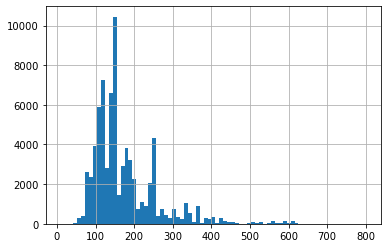

In [249]:
train['enginePower'].hist(bins=77)

In [250]:
train.enginePower.describe()

count    74009.000000
mean       175.236309
std         86.710744
min         11.000000
25%        117.000000
50%        150.000000
75%        200.000000
max        800.000000
Name: enginePower, dtype: float64

In [251]:
train[train.enginePower < 30]

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,sell_id,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,price_RUR,log_price,офДил,климат,подБез,усилРуля,отл,хор,цЗамок,эПодъм,бКомп,gearbox,drive4WD,engine_type,clearance_min
16392,Кабриолет,FORD,007F00,2.9,20,бензин,1000,1908,MODEL_T,2,1923,1082754038,MECHANICAL,AMERICAN,1.0,ORIGINAL,задний,LEFT,3800000.0,15.150512,0,0,0,0,0,0,0,0,0,MT,0,GASOLINE,160
49350,Купе,RENAULT,040001,2.0,11,электро,1800,2011,TWIZY,2,2016,1099636760,AUTOMATIC,EUROPEAN,2.0,ORIGINAL,задний,LEFT,549000.0,13.215854,0,0,0,0,0,0,0,0,0,AT,0,ELECTRO,120


Раритетный автомобиль 1923 года может иметь маленькую мощность, но не автомобиль 2016 года.

In [252]:
# Заменим на 150
mask = train['enginePower']==11
train.loc[mask, 'enginePower'] = 150

In [253]:
train[train.enginePower > 600]

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,sell_id,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,price_RUR,log_price,офДил,климат,подБез,усилРуля,отл,хор,цЗамок,эПодъм,бКомп,gearbox,drive4WD,engine_type,clearance_min
3372,Универсал 5 дв.,AUDI,22A0F8,4.0,605,бензин,29620,2014,RS6,5,2017,1101741980,AUTOMATIC,EUROPEAN,2.0,ORIGINAL,полный,LEFT,6050000.0,15.615569,0,0,0,0,0,0,0,0,0,AT,1,GASOLINE,110
3380,Лифтбек Sportback,AUDI,0000CC,4.0,605,бензин,17000,2014,RS7,5,2016,1101734424,AUTOMATIC,EUROPEAN,2.0,ORIGINAL,полный,LEFT,5600000.0,15.538277,0,0,0,0,0,0,0,0,0,AT,1,GASOLINE,110
3381,Лифтбек Sportback,AUDI,040001,4.0,605,бензин,35395,2014,RS7,5,2016,1101787478,AUTOMATIC,EUROPEAN,2.0,DUPLICATE,полный,LEFT,5399000.0,15.501724,0,0,0,0,1,0,0,0,0,AT,1,GASOLINE,110
3382,Лифтбек Sportback,AUDI,CACECB,4.0,605,бензин,53000,2014,RS7,5,2016,1101526187,AUTOMATIC,EUROPEAN,1.0,ORIGINAL,полный,LEFT,5100000.0,15.444751,0,0,0,0,0,0,0,0,0,AT,1,GASOLINE,110
3424,Седан,AUDI,0000CC,4.0,605,бензин,46842,2013,S8,4,2016,1101908047,AUTOMATIC,EUROPEAN,2.0,ORIGINAL,полный,LEFT,5250000.0,15.473739,0,0,0,0,1,0,0,0,0,AT,1,GASOLINE,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72822,Купе,MERCEDES,FAFBFB,4.0,612,бензин,18000,2017,S_KLASSE_AMG,2,2019,1102014976,AUTOMATIC,EUROPEAN,1.0,ORIGINAL,полный,LEFT,10200000.0,16.137898,0,0,0,0,0,0,0,0,0,AT,1,GASOLINE,160
72824,Седан,MERCEDES,040001,4.0,612,бензин,43643,2017,S_KLASSE_AMG,4,2019,1101432524,AUTOMATIC,EUROPEAN,1.0,ORIGINAL,полный,LEFT,9658000.0,16.083297,0,0,0,0,0,0,0,0,0,AT,1,GASOLINE,160
72826,Седан,MERCEDES,040001,4.0,612,бензин,17000,2017,S_KLASSE_AMG,4,2017,1099229048,AUTOMATIC,EUROPEAN,3.0,ORIGINAL,полный,LEFT,9900000.0,16.108045,0,0,0,0,0,0,0,0,0,AT,1,GASOLINE,160
72832,Седан,MERCEDES,040001,4.0,612,бензин,27000,2017,S_KLASSE_AMG,4,2018,1101700536,AUTOMATIC,EUROPEAN,1.0,ORIGINAL,полный,LEFT,9850000.0,16.102982,0,0,0,0,0,0,0,0,0,AT,1,GASOLINE,160


Верхняя граница выглядит вполне естественной.

### 4.14. productionDate

In [254]:
test.productionDate.value_counts()

2012    2798
2008    2606
2011    2589
2013    2488
2014    2134
        ... 
1936       1
1904       1
1967       1
1960       1
1952       1
Name: productionDate, Length: 69, dtype: int64

In [255]:
# расчитаем возраст автомобиля
train['years_old'] = 2021 - train['productionDate']
test['years_old'] = 2021 - test['productionDate']

<AxesSubplot:>

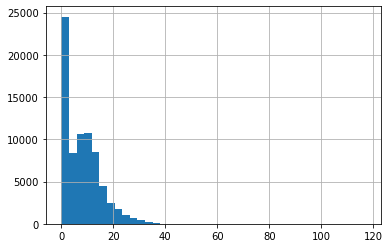

In [256]:
train.years_old.hist(bins=40)

In [257]:
train.years_old.describe()

count    74009.000000
mean         7.864462
std          7.210088
min          0.000000
25%          1.000000
50%          7.000000
75%         12.000000
max        117.000000
Name: years_old, dtype: float64

In [258]:
test.years_old.describe()

count    34686.000000
mean        11.735398
std          7.047661
min          1.000000
25%          7.000000
50%         10.000000
75%         15.000000
max        117.000000
Name: years_old, dtype: float64

In [259]:
test[test.years_old >= 80]

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,sell_id,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,офДил,климат,подБез,усилРуля,отл,хор,цЗамок,эПодъм,бКомп,gearbox,drive4WD,engine_type,clearance_min,years_old
1777,хэтчбек 3 дв.,SKODA,чёрный,1.1,30,бензин,14000,1934,POPULAR,3,1939,1097046168,механическая,EUROPEAN,3 или более,Оригинал,задний,Левый,0,0,0,0,0,0,0,0,0,MT,0,GASOLINE,150,82
3174,седан,AUDI,чёрный,3.3,75,бензин,90000,1938,920,4,1938,1091525266,механическая,EUROPEAN,2 владельца,Оригинал,задний,Левый,0,0,0,0,0,0,0,0,0,MT,0,GASOLINE,150,83
9625,седан,BMW,бежевый,2.0,51,бензин,16000,1936,326,4,1937,1094373106,механическая,EUROPEAN,2 владельца,Оригинал,задний,Левый,0,0,0,0,0,0,0,0,0,MT,0,GASOLINE,150,84
9819,седан 2 дв.,BMW,чёрный,2.0,46,бензин,4500,1937,321,2,1937,1040149625,механическая,EUROPEAN,3 или более,Оригинал,задний,Левый,0,0,0,0,0,0,0,1,0,MT,0,GASOLINE,150,84
16891,седан,MERCEDES,красный,1.7,38,бензин,1,1936,W136,4,1936,1099428966,механическая,EUROPEAN,1 владелец,Оригинал,задний,Левый,0,0,0,0,0,0,0,0,0,MT,0,GASOLINE,150,85
16944,кабриолет,MERCEDES,белый,5.3,32,бензин,48000,1904,SIMPLEX,0,1904,1093802104,механическая,EUROPEAN,1 владелец,Оригинал,задний,Правый,0,0,0,0,0,0,0,0,0,MT,0,GASOLINE,150,117


In [260]:
# сам productionDate можно удалить: новый признак его заменяет полностью
test.drop('productionDate', axis=1, inplace=True)
train.drop('productionDate', axis=1, inplace=True)

### 4.15. modelDate

In [261]:
train.modelDate.value_counts()

2018    6461
2017    6392
2019    5718
2020    4993
2010    4151
        ... 
1961       1
1908       1
1952       1
1969       1
1966       1
Name: modelDate, Length: 72, dtype: int64

In [262]:
train.modelDate.value_counts()

2018    6461
2017    6392
2019    5718
2020    4993
2010    4151
        ... 
1961       1
1908       1
1952       1
1969       1
1966       1
Name: modelDate, Length: 72, dtype: int64

Наиболее распространены модели 2017 и 2018 года.

### 4.16. mileage

In [263]:
train.mileage.describe()

count      74009.000000
mean      105103.500966
std       104070.245786
min            0.000000
25%            0.000000
50%        91620.000000
75%       169538.000000
max      1000000.000000
Name: mileage, dtype: float64

In [264]:
train.groupby('years_old').mileage.mean().head(10)

years_old
0         0.000000
1       212.021154
2     24140.490630
3     51216.131832
4     71665.126244
5     88546.289226
6    100813.407538
7    115642.198191
8    127827.793364
9    138384.085661
Name: mileage, dtype: float64

В среднем за первый год машина проходит до 10 000 км, а после по 20 000

In [265]:
train[train.mileage == 0].years_old.tail(20)

74632    0
74635    0
74641    0
74646    0
74647    0
74648    0
74649    1
74650    1
74651    1
74652    1
74653    1
74655    1
74660    1
74664    1
74666    1
74670    1
74673    1
74680    0
74682    0
74687    1
Name: years_old, dtype: int64

Машины новые, но 0 км всё же мало. Пока оставим как есть.

In [266]:
import plotly.graph_objs as go
from plotly.offline import plot, iplot

In [267]:
# построим график пробега от возраста машины
years_mileage = train.groupby('years_old')[['mileage']].sum().join(
    train.groupby('years_old')[['brand']].count()
)
years_mileage.columns = ['mileage', 'brand']

# создаем линию для километража
trace1 = go.Scatter(
    x=years_mileage.index,
    y=years_mileage.mileage,
    name='mileage'
)

layout = {'title': 'Statistics of mileage'} # title для графика

# cоздаем объект Figure и визуализируем его
fig = go.Figure(data=trace1, layout=layout)
iplot(fig, show_link=False)

Наибольший пробег у машин 9ти и 13 лет

## Категориальные признаки

### 4.17. bodyType

In [268]:
# Приведем к единому регистру
train.bodyType = train.bodyType.str.lower()

In [269]:
test.bodyType.value_counts(ascending=False).index[:9]

Index(['седан', 'внедорожник 5 дв.', 'лифтбек', 'хэтчбек 5 дв.',
       'универсал 5 дв.', 'минивэн', 'купе', 'компактвэн', 'хэтчбек 3 дв.'],
      dtype='object')

In [270]:
train.bodyType.value_counts(ascending=False).index[:9]

Index(['внедорожник 5 дв.', 'седан', 'хэтчбек 5 дв.', 'лифтбек',
       'универсал 5 дв.', 'минивэн', 'компактвэн', 'купе', 'хэтчбек 3 дв.'],
      dtype='object')

9 основных типов кузовов в трейне и тесте совпадают. Заменим остальные типы кузовов общим типом 'other'

In [271]:
bodyType = list(test.bodyType.value_counts(ascending=False).index[:9])

In [272]:
train['bodyType'] = train['bodyType'].apply(lambda x: x if x in bodyType else 'other')
test['bodyType'] = test['bodyType'].apply(lambda x: x if x in bodyType else 'other')

Проверим что все верно

In [273]:
train['bodyType'].value_counts()

внедорожник 5 дв.    32833
седан                20098
хэтчбек 5 дв.         5828
other                 5083
лифтбек               3257
универсал 5 дв.       2323
минивэн               1330
компактвэн            1238
купе                  1015
хэтчбек 3 дв.         1004
Name: bodyType, dtype: int64

### 4.18. brand

In [274]:
test.brand.value_counts(ascending=False).index

Index(['BMW', 'VOLKSWAGEN', 'NISSAN', 'MERCEDES', 'TOYOTA', 'AUDI',
       'MITSUBISHI', 'SKODA', 'VOLVO', 'HONDA', 'INFINITI', 'LEXUS'],
      dtype='object')

In [275]:
train.brand.value_counts(ascending=False).index

Index(['MERCEDES', 'BMW', 'VOLKSWAGEN', 'NISSAN', 'KIA', 'HYUNDAI', 'RENAULT',
       'AUDI', 'MITSUBISHI', 'TOYOTA', 'SKODA', 'FORD', 'CHEVROLET', 'OPEL',
       'MAZDA', 'VOLVO', 'LAND_ROVER', 'PEUGEOT', 'LEXUS', 'SUZUKI', 'CITROEN',
       'HONDA', 'INFINITI', 'PORSCHE', 'SUBARU', 'DAEWOO', 'MINI', 'JEEP',
       'SSANG_YONG', 'CHERY', 'HAVAL', 'CADILLAC', 'GREAT_WALL'],
      dtype='object')

In [276]:
print(f'{len(test.brand.value_counts())} уникальных бренда в тесте и {len(train.brand.value_counts())} бренда в трейне')

12 уникальных бренда в тесте и 33 бренда в трейне


In [277]:
# Основные типы не совпадают. Оставим в трейне только те бренды, что есть в тесте.
brand = list(test.brand.unique())
train['brand'] = train['brand'].apply(lambda x: x if x in brand else 'other')

In [278]:
# Проверка
train['brand'].value_counts()

other         31725
MERCEDES       9041
BMW            5907
VOLKSWAGEN     5537
NISSAN         5530
AUDI           3430
MITSUBISHI     3053
TOYOTA         2998
SKODA          2985
VOLVO          1437
LEXUS           947
HONDA           764
INFINITI        655
Name: brand, dtype: int64

### 4.19. color

In [279]:
# color в train представлен в шестнадцатеричной системе. Приведем к единому виду
color_dict = {'040001':'чёрный', 'EE1D19':'красный', '0000CC':'синий', 
              'CACECB':'серебристый', '007F00':'зелёный', 'FAFBFB':'белый', 
              '97948F':'серый', '22A0F8':'голубой', '660099':'пурпурный', 
              '200204':'коричневый', 'C49648':'бежевый', 'DEA522':'золотистый', 
              '4A2197':'фиолетовый', 'FFD600':'жёлтый', 'FF8649':'оранжевый', 
              'FFC0CB':'розовый'}
train['color'] = train['color'].map(color_dict)

In [280]:
train.color.value_counts(ascending=False).index

Index(['чёрный', 'белый', 'серый', 'серебристый', 'синий', 'красный',
       'коричневый', 'зелёный', 'бежевый', 'голубой', 'оранжевый', 'жёлтый',
       'золотистый', 'пурпурный', 'фиолетовый', 'розовый'],
      dtype='object')

In [281]:
test.color.value_counts(ascending=False).index

Index(['чёрный', 'белый', 'серебристый', 'серый', 'синий', 'красный',
       'коричневый', 'зелёный', 'бежевый', 'голубой', 'золотистый',
       'пурпурный', 'фиолетовый', 'жёлтый', 'оранжевый', 'розовый'],
      dtype='object')

### 4.20. fuelType

In [282]:
train.fuelType.value_counts()

бензин     61241
дизель     12491
гибрид       177
электро       88
газ           12
Name: fuelType, dtype: int64

In [283]:
test.fuelType.value_counts()

бензин     28601
дизель      5800
гибрид       223
электро       55
газ            7
Name: fuelType, dtype: int64

Категориальный признак. Данные все.

### 4.21. model_name

In [284]:
print(f'{len(test.model_name.value_counts())} уникальных бренда в тесте и {len(train.model_name.value_counts())} бренда в трейне')

544 уникальных бренда в тесте и 992 бренда в трейне


In [285]:
test.model_name.value_counts(ascending=False).index[:15]

Index(['OCTAVIA', '5ER', 'LANCER', 'E_KLASSE', 'PASSAT', 'A6', '3ER', 'POLO',
       'CAMRY', 'X5', 'X_TRAIL', 'A4', 'QASHQAI', 'S_KLASSE', 'OUTLANDER'],
      dtype='object')

In [286]:
train.model_name.value_counts(ascending=False).index[:15]

Index(['X_TRAIL', 'POLO', 'QASHQAI', 'RIO', 'E_KLASSE', 'FOCUS', 'SOLARIS',
       'OCTAVIA', 'OUTLANDER', '3ER', 'SANDERO', 'CRETA', 'TIGUAN', 'LOGAN',
       'ASTRA'],
      dtype='object')

Совпадения по основным моделям не прослеживается. Пока оставляем.

### 4.22. numberOfDoors

In [287]:
test.numberOfDoors.value_counts()

5    18703
4    14126
2     1206
3      650
0        1
Name: numberOfDoors, dtype: int64

In [288]:
test[test.numberOfDoors==0]

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,sell_id,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,офДил,климат,подБез,усилРуля,отл,хор,цЗамок,эПодъм,бКомп,gearbox,drive4WD,engine_type,clearance_min,years_old
16944,other,MERCEDES,белый,5.3,32,бензин,48000,1904,SIMPLEX,0,1093802104,механическая,EUROPEAN,1 владелец,Оригинал,задний,Правый,0,0,0,0,0,0,0,0,0,MT,0,GASOLINE,150,117


In [289]:
train.numberOfDoors.value_counts()

5    48524
4    22350
3     1678
2     1456
0        1
Name: numberOfDoors, dtype: int64

In [290]:
train[train.numberOfDoors<=2]

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,sell_id,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,price_RUR,log_price,офДил,климат,подБез,усилРуля,отл,хор,цЗамок,эПодъм,бКомп,gearbox,drive4WD,engine_type,clearance_min,years_old
699,other,AUDI,красный,2.0,200,бензин,170000,2004,A4,2,1096050216,AUTOMATIC,EUROPEAN,1.0,ORIGINAL,полный,LEFT,1300000.0,14.077875,0,0,0,0,0,0,0,0,0,AT,1,GASOLINE,130,12
1151,купе,AUDI,белый,2.0,225,бензин,125000,2011,A5,2,1101572798,ROBOT,EUROPEAN,1.0,ORIGINAL,полный,LEFT,1459000.0,14.193262,0,0,0,0,0,0,0,0,0,AMT,1,GASOLINE,120,7
1155,купе,AUDI,серый,2.7,190,дизель,147738,2007,A5,2,1102084445,VARIATOR,EUROPEAN,2.0,ORIGINAL,передний,LEFT,775000.0,13.560618,0,0,0,0,1,0,0,0,0,CVT,0,DIESEL,120,13
1156,купе,AUDI,зелёный,2.0,249,бензин,0,2019,A5,2,1101779851,ROBOT,EUROPEAN,NaN,ORIGINAL,полный,LEFT,3590000.0,15.093663,0,0,0,0,0,0,0,0,0,AMT,1,GASOLINE,160,1
1161,купе,AUDI,белый,2.0,211,бензин,75250,2011,A5,2,1102054034,ROBOT,EUROPEAN,1.0,ORIGINAL,полный,LEFT,1370000.0,14.130321,0,0,0,0,0,0,0,0,0,AMT,1,GASOLINE,120,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73286,other,MERCEDES,коричневый,2.2,120,бензин,50000,1958,W128,2,1101388727,MECHANICAL,EUROPEAN,1.0,ORIGINAL,задний,LEFT,14980878.0,16.522285,0,0,0,0,0,0,0,0,0,MT,0,GASOLINE,160,62
73287,купе,MERCEDES,серебристый,2.2,120,бензин,5000,1958,W128,2,1096244830,MECHANICAL,EUROPEAN,1.0,ORIGINAL,задний,LEFT,18000000.0,16.705882,0,0,0,0,0,0,0,0,0,MT,0,GASOLINE,160,62
73288,купе,MERCEDES,коричневый,2.2,120,бензин,1000,1958,W128,2,1095769120,MECHANICAL,EUROPEAN,1.0,ORIGINAL,задний,LEFT,15900000.0,16.581830,0,0,0,0,0,0,0,0,0,MT,0,GASOLINE,160,62
73292,купе,MERCEDES,чёрный,3.0,150,бензин,12000,1951,W188,2,1100192650,MECHANICAL,EUROPEAN,3.0,ORIGINAL,задний,LEFT,52500000.0,17.776324,0,0,0,0,0,0,0,0,0,MT,0,GASOLINE,210,69


Модели с 2 и менее дверей раритетные или эксклюзивные

### 4.23. vehileTransmission

In [291]:
test.vehicleTransmission.value_counts()

автоматическая      19596
механическая         7209
вариатор             3999
роботизированная     3882
Name: vehicleTransmission, dtype: int64

In [292]:
train.vehicleTransmission.value_counts()

AUTOMATIC     40099
MECHANICAL    18674
ROBOT          8079
VARIATOR       7157
Name: vehicleTransmission, dtype: int64

In [293]:
# Приведем к единому написанию
train.vehicleTransmission = train.vehicleTransmission.apply(lambda x: 'автоматическая' if x == 'AUTOMATIC' else 'механическая' if x == 'MECHANICAL' else 'вариатор' if x == 'VARIATOR' else 'роботизированная' )

### 4.24. vendor

In [294]:
test.vendor.value_counts()

EUROPEAN    20682
JAPANESE    14004
Name: vendor, dtype: int64

In [295]:
train.vendor.value_counts()

EUROPEAN    38867
JAPANESE    17232
KOREAN      10469
AMERICAN     5529
CHINESE      1076
RUSSIAN       836
Name: vendor, dtype: int64

### 4.25. Владельцы

In [296]:
#пропущенных значений
train.Владельцы.isna().sum()

21853

In [297]:
train.Владельцы.value_counts()

3.0    21236
1.0    16517
2.0    13922
4.0      481
Name: Владельцы, dtype: int64

In [298]:
train.Владельцы = train.Владельцы.fillna('3')

In [299]:
# Приведем к единому виду
train.Владельцы = train.Владельцы.astype('str')
test.Владельцы = test.Владельцы.astype('str')

In [300]:
train.Владельцы = train.Владельцы.apply(lambda x: x[0])
test.Владельцы = test.Владельцы.apply(lambda x: x[0])

In [301]:
train.Владельцы = train.Владельцы.values.astype('int64')
test.Владельцы = test.Владельцы.values.astype('int64')

### 4.26. Привод¶

In [302]:
test.Привод.value_counts()

передний    15565
полный      15020
задний       4101
Name: Привод, dtype: int64

In [303]:
train.Привод.value_counts()

передний    37120
полный      32118
задний       4771
Name: Привод, dtype: int64

## Бинарные признаки

### 4.27. Руль

In [304]:
train.Руль.value_counts()

LEFT     72848
RIGHT     1161
Name: Руль, dtype: int64

In [305]:
test.Руль.value_counts()

Левый     33287
Правый     1399
Name: Руль, dtype: int64

In [306]:
# Приведем к единому написанию
train.Руль = train.Руль.apply(lambda x: 'Левый' if x == 'LEFT' else 'Правый')

### 4.28. ПТС

In [307]:
train.ПТС.value_counts()

ORIGINAL     67557
DUPLICATE     6452
Name: ПТС, dtype: int64

In [308]:
test.ПТС.value_counts()

Оригинал    30099
Дубликат     4587
Name: ПТС, dtype: int64

In [309]:
#Приведем к единому написанию
train.ПТС = train.ПТС.apply(lambda x: 'Оригинал' if x == 'ORIGINAL' else 'Дубликат')

## Визуализация признаков

In [310]:
test.isna().sum()

bodyType               0
brand                  0
color                  0
engineDisplacement     0
enginePower            0
fuelType               0
mileage                0
modelDate              0
model_name             0
numberOfDoors          0
sell_id                0
vehicleTransmission    0
vendor                 0
Владельцы              0
ПТС                    0
Привод                 0
Руль                   0
офДил                  0
климат                 0
подБез                 0
усилРуля               0
отл                    0
хор                    0
цЗамок                 0
эПодъм                 0
бКомп                  0
gearbox                0
drive4WD               0
engine_type            0
clearance_min          0
years_old              0
dtype: int64

In [311]:
train.isna().sum()

bodyType               0
brand                  0
color                  0
engineDisplacement     0
enginePower            0
fuelType               0
mileage                0
modelDate              0
model_name             0
numberOfDoors          0
sell_id                0
vehicleTransmission    0
vendor                 0
Владельцы              0
ПТС                    0
Привод                 0
Руль                   0
price_RUR              0
log_price              0
офДил                  0
климат                 0
подБез                 0
усилРуля               0
отл                    0
хор                    0
цЗамок                 0
эПодъм                 0
бКомп                  0
gearbox                0
drive4WD               0
engine_type            0
clearance_min          0
years_old              0
dtype: int64

In [312]:
# Объединяем трейн и тест

train['Train'] = 1 # помечаем трейн
test['Train'] = 0 # помечаем тест

df = train.append(test, sort=False).reset_index(drop=True) # объединяем

In [313]:
# объединим все полученные признаки по категориям

bin_cols = ['ПТС', 'Руль', 'офДил', 'климат', 'подБез', 'усилРуля',
            'отл', 'хор', 'цЗамок', 'эПодъм', 'бКомп', 'drive4WD']
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'numberOfDoors',
            'vehicleTransmission', 'vendor', 'Владельцы', 'Привод', 'gearbox', 'engine_type']
num_cols = ['modelDate', 'years_old', 'engineDisplacement', 'mileage', 'clearance_min', 'enginePower']# sell_id исключили из списка

### Числовые признаки

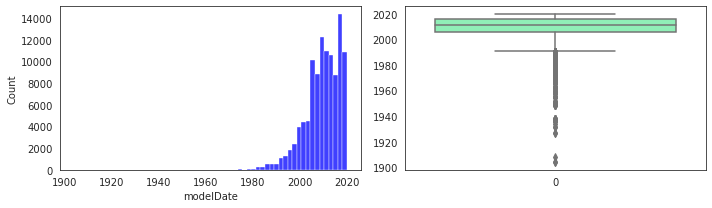

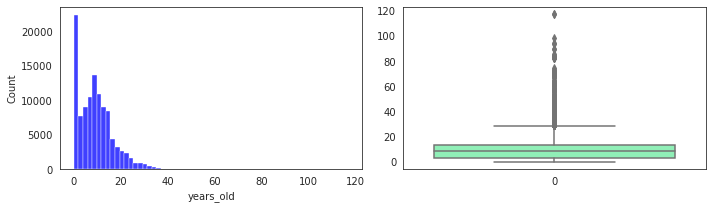

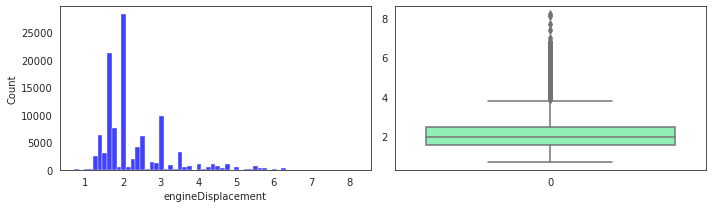

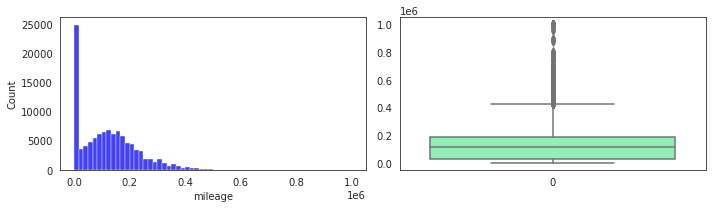

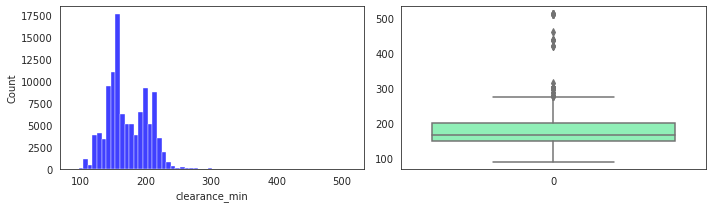

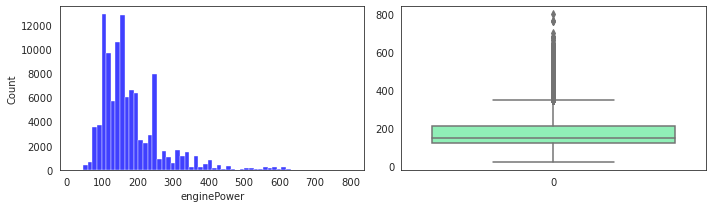

In [314]:
# Рассмотрим числовые признаки
for i in num_cols:
    f = plt.figure(figsize=(10, 3))
    gs = f.add_gridspec(1, 2)
    with sns.axes_style("white"):
        ax = f.add_subplot(gs[0, 0])
        sns.histplot(df[i], kde = False, bins=60, color='b')

    with sns.axes_style("white"):
        ax = f.add_subplot(gs[0, 1])
        sns.boxplot(data=df[i], palette='rainbow')

    f.tight_layout()


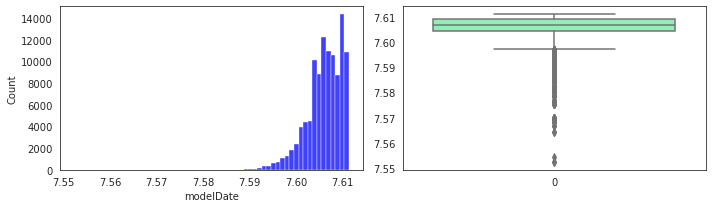

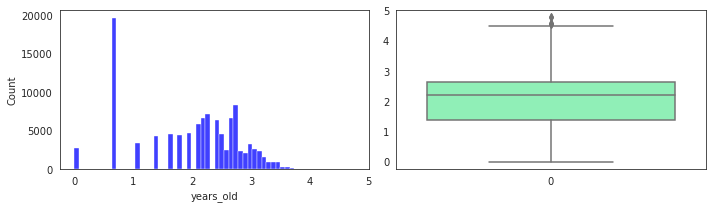

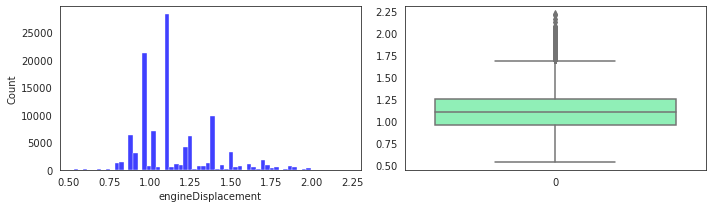

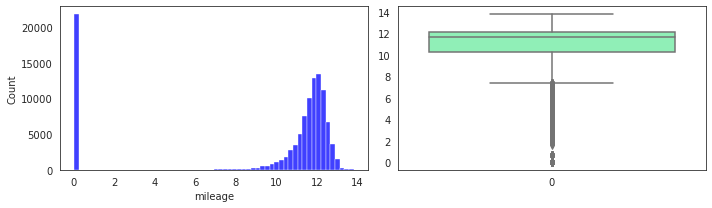

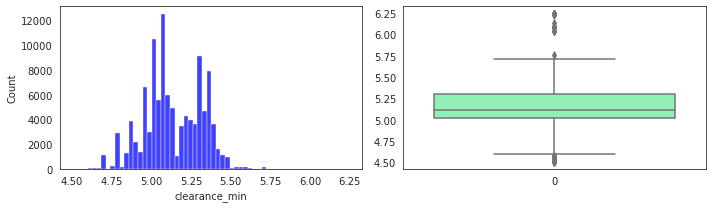

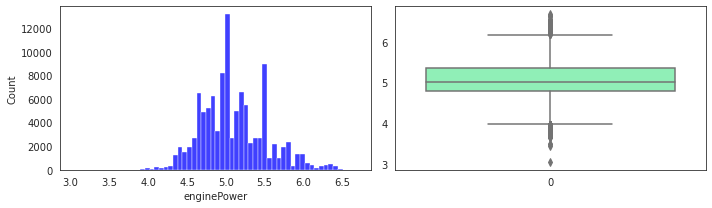

In [315]:
# У всех признаков имеются выбросы.
# пробуем логарифмировать

for i in num_cols:
    df[i] = np.log(df[i] + 1)
    f = plt.figure(figsize=(10, 3))
    gs = f.add_gridspec(1, 2)
    with sns.axes_style("white"):
        ax = f.add_subplot(gs[0, 0])
        sns.histplot(df[i], kde = False, bins=60, color='b')

    with sns.axes_style("white"):
        ax = f.add_subplot(gs[0, 1])
        sns.boxplot(data=df[i], palette='rainbow')

    f.tight_layout()


От выбросов избавиться не удалось.

<AxesSubplot:>

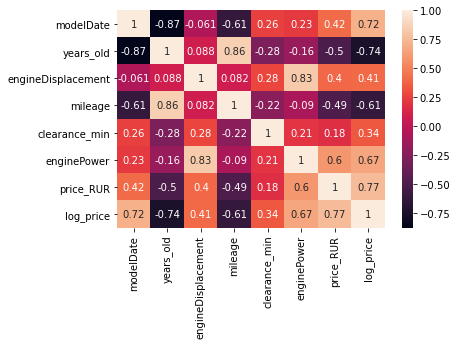

In [316]:
# Корреляция для числовых признаков
column = ['modelDate', 'years_old', 'engineDisplacement', 'mileage', 'clearance_min', 'enginePower', 'price_RUR', 'log_price']
df_num = df[column]
sns.heatmap(df_num.corr(), annot = True)

Высокая корреляция между enginePower и engineDisplacement и обратная корреляция между modelDate и years_old.         
С price_RUR и log_price коррелируют enginePower, modelDate, обратная корреляция с years_old и mileage.      
На данном этапе берем информацию к сведению.

### Категориальные и бинарные признаки

In [317]:
for column in cat_cols:
    df[column] = df[column].astype('category').cat.codes

for i in cat_cols:
    f = plt.figure(figsize=(15, 3))
    gs = f.add_gridspec(1, 4)
    with sns.axes_style("white"):
        ax = f.add_subplot(gs[0, 0])
        sns.barplot(x=i, y='price_RUR', data=df[df['Train'] ==1], estimator=len)
        
    with sns.axes_style("white"):
        ax = f.add_subplot(gs[0, 1])
        sns.barplot(x='price_RUR', y=i, data=df[df['Train'] ==1], estimator=len)

    with sns.axes_style("white"):
        ax = f.add_subplot(gs[0, 2])
        sns.boxplot(x='price_RUR', y=i, data=df[df['Train'] ==1], palette='rainbow')
        
    with sns.axes_style("white"):
        ax = f.add_subplot(gs[0, 3])
        sns.boxplot(data=df[i], palette='rainbow')

    f.tight_layout()

In [318]:
# Корреляция категориальных признаков между собой
round(df[cat_cols].corr(method='spearman'), 1)

,bodyType,brand,color,fuelType,model_name,numberOfDoors,vehicleTransmission,vendor,Владельцы,Привод,gearbox,engine_type
bodyType,1.0,0.1,-0.0,-0.2,-0.3,-0.4,0.2,-0.0,0.0,-0.5,0.1,0.2
brand,0.1,1.0,-0.1,-0.1,0.1,0.1,0.1,0.1,-0.0,-0.2,0.2,0.1
color,-0.0,-0.1,1.0,0.1,-0.0,-0.0,-0.1,-0.1,0.0,0.1,-0.1,-0.1
fuelType,-0.2,-0.1,0.1,1.0,0.1,0.1,-0.2,-0.1,-0.0,0.3,-0.1,-1.0
model_name,-0.3,0.1,-0.0,0.1,1.0,0.3,-0.0,0.1,-0.1,0.2,0.0,-0.1
numberOfDoors,-0.4,0.1,-0.0,0.1,0.3,1.0,-0.0,0.0,-0.0,0.4,-0.0,-0.1
vehicleTransmission,0.2,0.1,-0.1,-0.2,-0.0,-0.0,1.0,-0.1,0.0,-0.2,0.3,0.2
vendor,-0.0,0.1,-0.1,-0.1,0.1,0.0,-0.1,1.0,-0.1,0.0,0.2,0.1
Владельцы,0.0,-0.0,0.0,-0.0,-0.1,-0.0,0.0,-0.1,1.0,-0.0,0.0,0.0
Привод,-0.5,-0.2,0.1,0.3,0.2,0.4,-0.2,0.0,-0.0,1.0,-0.2,-0.3


In [319]:
label_encoder = LabelEncoder()
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

In [320]:
df.sample(5)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,sell_id,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,price_RUR,log_price,офДил,климат,подБез,усилРуля,отл,хор,цЗамок,эПодъм,бКомп,gearbox,drive4WD,engine_type,clearance_min,years_old,Train
46710,6,12,15,0.955511,4.634729,0,11.736077,7.607381,568,3,1102005682,2,2,0,1,1,0,410000.0,12.923912,0,0,0,0,0,1,0,0,0,3,0,2,5.049856,2.079442,1
92091,6,5,15,0.955511,5.056246,0,11.461643,7.606885,298,3,1090899904,0,2,1,1,0,0,NaN,NaN,0,0,0,0,0,0,0,0,0,1,0,2,5.017280,2.197225,0
106411,1,6,6,1.223776,5.204007,3,10.571343,7.608871,663,4,1101346405,0,3,1,1,2,0,NaN,NaN,0,0,0,0,0,0,0,0,0,1,1,0,5.389072,1.386294,0
85805,1,7,12,1.098612,4.976734,0,9.105091,7.609862,720,4,1100808614,1,3,0,1,2,0,NaN,NaN,0,0,0,0,0,0,0,0,0,2,1,2,5.303305,0.693147,0
39398,1,7,15,1.252763,5.147494,0,10.229549,7.607878,1020,4,1102061709,1,3,0,1,2,0,1689000.0,14.339647,0,0,0,0,0,0,0,0,0,2,1,2,5.351858,1.791759,1


In [321]:
df.drop('log_price', axis=1, inplace=True)

<AxesSubplot:title={'center':'Значимость числовых переменных'}>

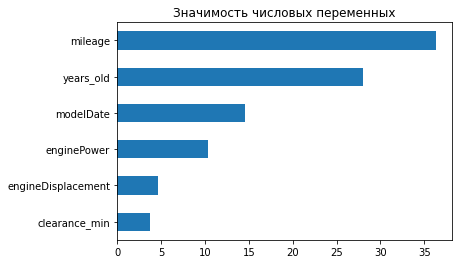

In [322]:
# Значимость числовых признаков
train_df = df[df['Train']==1]
imp_num = pd.Series(f_classif(train_df[num_cols], train_df['price_RUR'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость числовых переменных')

<AxesSubplot:title={'center':'Значимость бинарных и категориальных признаков'}>

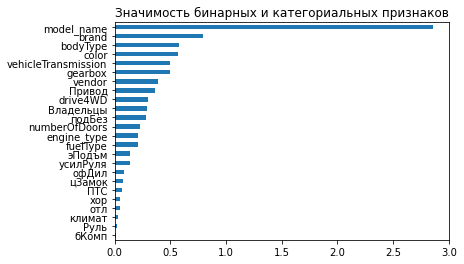

In [323]:
# Значимость бинарных и категориальных признаков

from pandas import Series

imp_cat = Series(mutual_info_classif(train_df[bin_cols + cat_cols], train_df['price_RUR'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', title = 'Значимость бинарных и категориальных признаков')

In [324]:
import requests, json
# Запись датасета
df.to_csv('auto_featured.csv', index=False)

# Submission

submit['price'] = predict_submission
submit.to_csv('submission_2_v1.csv', index=False)
submit.head(10)